# Scattering for Emission Spectra

Here we describe the scattering implementation of pRT. It is based on the implementation of [petitCODE](https://www2.mpia-hd.mpg.de/homes/molliere/#petitcode), which is described in detail in Section 3.2 of [this PhD thesis](http://www.ub.uni-heidelberg.de/archiv/23252).

## Self-scattering in gas giants

Self-scattering is the process to consider for (cloudy) brown dwarfs and directly imaged planets. Self-scattering means that photons originating in the planetary atmosphere will be scattered. The reference for self-scattering in pRT is [Mollière et al. (2020)](https://arxiv.org/abs/2006.09394).

To turn on scattering one must simply pass the keyword ``do_scat_emis = True`` to ``Radtrans()`` when initializing the pRT object. Here we will take the setup similar to the example described in ["Clouds"](clouds.html), considering a Mg$_2$SiO$_4$ cloud.

In [1]:
import numpy as np
import pylab as plt

plt.rcParams['figure.figsize'] = (10, 6)
from petitRADTRANS import Radtrans
from petitRADTRANS import nat_cst as nc

# Load scattering version of pRT
atmosphere = Radtrans(line_species = ['H2O_HITEMP',
                                      'CO_all_iso_HITEMP',
                                      'CH4',
                                      'CO2',
                                      'Na_allard',
                                      'K_allard'],
                      cloud_species = ['Mg2SiO4(c)_cd'],
                      rayleigh_species = ['H2', 'He'],
                      continuum_opacities = ['H2-H2', 'H2-He'],
                      wlen_bords_micron = [0.3, 15],
                      do_scat_emis = True)

pressures = np.logspace(-6, 2, 100)
atmosphere.setup_opa_structure(pressures)

  Read line opacities of CH4...
 Done.
  Read line opacities of CO2...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



Here we define the atmosphere, and some cloud parameters. Again, see the ["Clouds"](clouds.html) page for more information. The parameters are chosen more appropriately for a directly imaged object, specifically by also setting $T_{\rm eq}=0$. **Note that these are freely made up values, however. The P-T profile of a real directly imaged planet may well be different (e.g., not isothermal at low pressures). Also the abundances are just made up for this simple example here** (see ["Interpolating chemical equilibrium abundances"](poor_man.html) for how to improve this.). We set the cloud mass fraction to be zero for pressures larger than 3 bar in this example, which is the location of our hypothetical cloud base. The cloud mass fraction is taken to decrease $\propto P^{f_{\rm sed}}$ above the cloud base here, where $P$ is the pressure and $f_{\rm sed}$ the settling parameter, so as to account for the settling of cloud particles, as motivated by the [Ackerman & Marley (2001) cloud model](https://ui.adsabs.harvard.edu/abs/2001ApJ...556..872A/abstract). In principle any other vertical profile can be chosen here. Also, a more realistic setup may place the cloud base at the location where the P-T curve and the saturation vapor pressure curve of a given cloud species intersect.

In [2]:
R_pl = 1.2*nc.r_jup_mean
gravity = 1e1**3.5

# P-T parameters
kappa_IR = 0.01
gamma = 0.4
T_int = 1200.
T_equ = 0.
temperature = nc.guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)

# Cloud parameters
Kzz = np.ones_like(temperature)*1e1**6.5
fsed = 2.
sigma_lnorm = 1.05

# Absorber mass fractions
mass_fractions = {}
mass_fractions['H2'] = 0.74 * np.ones_like(temperature)
mass_fractions['He'] = 0.24 * np.ones_like(temperature)
mass_fractions['H2O_HITEMP'] = 0.001 * np.ones_like(temperature)
mass_fractions['CO_all_iso_HITEMP'] = 0.005 * np.ones_like(temperature)
mass_fractions['CO2'] = 0.000001 * np.ones_like(temperature)
mass_fractions['CH4'] = 0.0000001 * np.ones_like(temperature)
mass_fractions['Na_allard'] = 0.00001 * np.ones_like(temperature)
mass_fractions['K_allard'] = 0.000001 * np.ones_like(temperature)

# Cloud mass fractions
mfr_cloud = np.zeros_like(temperature)
mfr_cloud[pressures<=3.] = 0.00005 * (pressures[pressures<=3.]/3.)**fsed
mass_fractions['Mg2SiO4(c)'] = mfr_cloud

MMW = 2.33 * np.ones_like(temperature)

This is the P-T profile we are using for our simple setup:

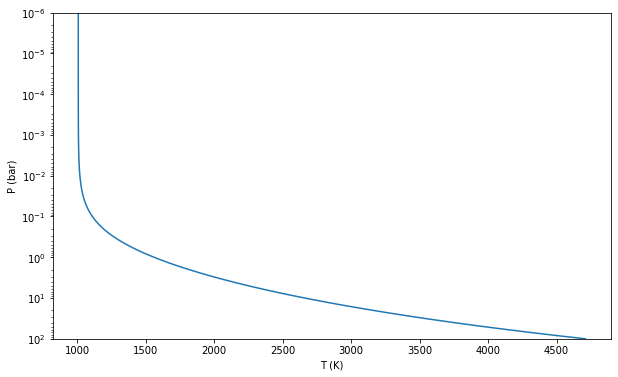

<Figure size 720x432 with 0 Axes>

In [3]:
plt.plot(temperature, pressures)
plt.yscale('log')
plt.ylim([1e2, 1e-6])
plt.xlabel('T (K)')
plt.ylabel('P (bar)')
plt.show()
plt.clf()

We will also compare to the cloud-free case, and the case neglecting scattering again. For the last case we have to initialize a pRT object with ``do_scat_emis = False``, or omit the ``do_scat_emis`` keyword altogether when initializing the pRT object.

In [4]:
atmosphere_no_scat = Radtrans(line_species = ['H2O_HITEMP',
                                              'CO_all_iso_HITEMP',
                                              'CH4',
                                              'CO2',
                                              'Na_allard',
                                              'K_allard'],
                              cloud_species = ['Mg2SiO4(c)_cd'],
                              rayleigh_species = ['H2', 'He'],
                              continuum_opacities = ['H2-H2', 'H2-He'],
                              wlen_bords_micron = [0.3, 15],
                              do_scat_emis = False)
pressures = np.logspace(-6, 2, 100)
atmosphere_no_scat.setup_opa_structure(pressures)

  Read line opacities of CH4...
 Done.
  Read line opacities of CO2...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



Now we will plot the spectra for the three cases, including scattering, neglecting scattering, and turning off the clouds. In addition, we set ``contribution = True`` in the ``calc_flux()`` methods, such that we can study the contribution functions of the cases below. See ["Analysis Tools"](analysis.html) for more information on emission contribution functions.

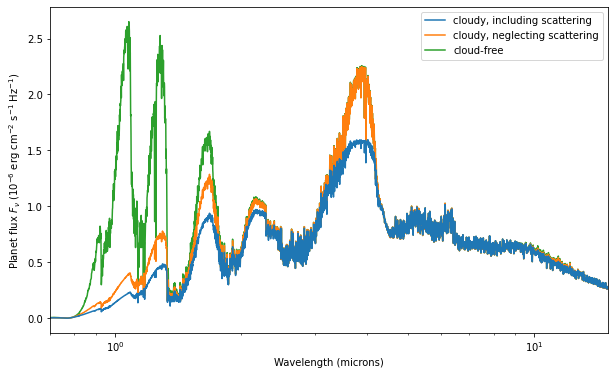

<Figure size 720x432 with 0 Axes>

In [5]:
import pylab as plt
mass_fractions['Mg2SiO4(c)'] = mfr_cloud

atmosphere.calc_flux(temperature, mass_fractions, gravity, MMW, \
                       Kzz = Kzz, fsed=fsed, sigma_lnorm = sigma_lnorm, \
                       contribution = True)
plt.plot(nc.c/atmosphere.freq/1e-4, atmosphere.flux/1e-6, \
         label = 'cloudy, including scattering', zorder = 2)
contribution_scat = atmosphere.contr_em

atmosphere_no_scat.calc_flux(temperature, mass_fractions, gravity, MMW, \
                       Kzz = Kzz, fsed=fsed, sigma_lnorm = sigma_lnorm, \
                       contribution = True)
plt.plot(nc.c/atmosphere_no_scat.freq/1e-4, atmosphere_no_scat.flux/1e-6, \
         label = 'cloudy, neglecting scattering', zorder = 1)
contribution_no_scat = atmosphere_no_scat.contr_em

mass_fractions['Mg2SiO4(c)'] = 0.0 * np.ones_like(temperature)

atmosphere_no_scat.calc_flux(temperature, mass_fractions, gravity, MMW, \
                       Kzz = Kzz, fsed=fsed, sigma_lnorm = sigma_lnorm,
                       contribution = True)

plt.plot(nc.c/atmosphere_no_scat.freq/1e-4, atmosphere_no_scat.flux/1e-6, \
         label = 'cloud-free', zorder = 0)
contribution_clear = atmosphere_no_scat.contr_em

plt.legend(loc='best')
plt.xlim([0.7, 15])
plt.xscale('log')
plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Planet flux $F_\nu$ (10$^{-6}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')
plt.show()
plt.clf()

Finally, we compare the emission contribution of the cloudy (with scattering) and clear case below. The cloud deck at 3 bar is clearly visible in the contribution function for the cloudy case, as it is cutting off the emission from the atmosphere between 2 and 3 bar.

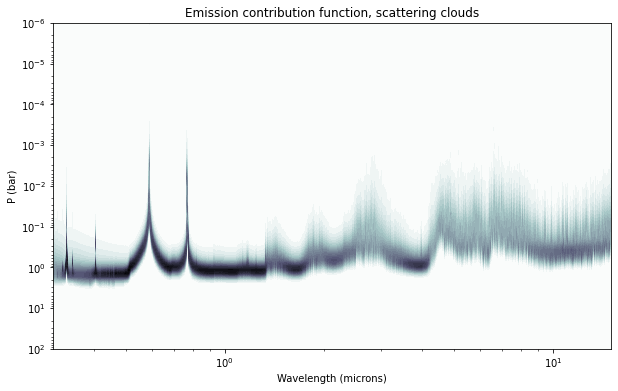

<Figure size 720x432 with 0 Axes>

In [6]:
wlen_mu = nc.c/atmosphere.freq/1e-4
X, Y = np.meshgrid(wlen_mu, pressures)
plt.contourf(X,Y,contribution_scat,30,cmap=plt.cm.bone_r)

plt.yscale('log')
plt.xscale('log')
plt.ylim([1e2,1e-6])
plt.xlim([np.min(wlen_mu),np.max(wlen_mu)])

plt.xlabel('Wavelength (microns)')
plt.ylabel('P (bar)')
plt.title('Emission contribution function, scattering clouds')
plt.show()
plt.clf()

In contrast, no clouds hide the deep hot regions from view in the clear case, allowing for pressures of multiple 10s of bars being probed in the optical.

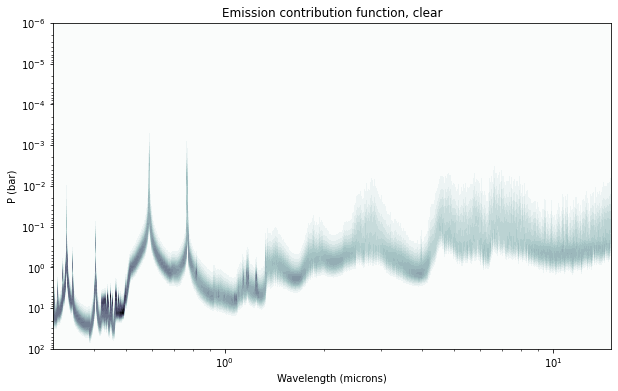

<Figure size 720x432 with 0 Axes>

In [7]:
plt.contourf(X,Y,contribution_clear,30,cmap=plt.cm.bone_r)

plt.yscale('log')
plt.xscale('log')
plt.ylim([1e2,1e-6])
plt.xlim([np.min(wlen_mu),np.max(wlen_mu)])

plt.xlabel('Wavelength (microns)')
plt.ylabel('P (bar)')
plt.title('Emission contribution function, clear')
plt.show()
plt.clf()

## Scattering of stellar light

For the optical and near-infrared spectra of close-in planets, also scattering of the stellar light can be important. We likewise ported this implementation from [petitCODE](https://www2.mpia-hd.mpg.de/homes/molliere/#petitcode) and verified the pRT results with petitCODE calculations. Together with the newly added surface scattering for terretrial planets, this will be described in detail in an upcoming paper (Alei et al., in prep.). For the planetary insolation, stellar spectra will be interpolated from the available PHOENIX/ATLAS9 spectra (see [Utility Functions](nat_cst_utility.html) section). To control the insolation flux contribution, a few more arguments are required when calling the ``calc_flux`` function. These are:


* ``geometry``: the geometry and dilution of the incoming stellar radiation field (see below for further information);
* ``Tstar``: the stellar effective temperature in K;
* ``Rstar``: the stellar radius in cm; if you don't specify a radius, pRT will take the stellar radius at 1/3 of the main sequence life time of star with the specified effective temperature, see [van Boekel et al. 2012](http://adsabs.harvard.edu/abs/2012SPIE.8442E..1FV); to specify your own radius (recommended when comparing to actual observations) you can use the ``nat_cst`` module to import constants in cgs, ``nc.r_sun`` is the solar radius in cm. This is also done in the examples below.
* ``semimajoraxis``: the distance of the planet from the star in cm; you can use the ``nat_cst`` module to import constants in cgs, ``nc.AU`` is the astronomical unit in cm.


## Geometries

The scattering of direct stellar light can be treated considering different geometries, specifiying the direction of the incoming stellar irradiation, and its absolute flux value. pRT offers three scenarios:

* the globally-averaged insolation (``geometry = planetary_ave``), that assumes that the stellar radiation reaches the atmosphere isotropically from above, and that its flux value is the average received over the full surface area of the planet. This translates into multiplying the stellar flux by a factor 1/4.
* the dayside-averaged insolation (``geometry = dayside_ave``), that assumes that the stellar radiation reaches the atmosphere isotropically and is the average received over the dayside of the planet. This translates into multiplying the stellar flux by a factor 1/2.
* the non-isotropic case (``geometry = non-isotropic``) which assumes that the stellar radiation comes from a specific direction, with respect to the atmospheric normal vector. The angle between the incoming stellar light and the atmospheric normal, $\vartheta_* \in [0,90^\circ]$, must be provided by the user with ``theta_star`` parameter. For example, an angle of $0^\circ$ means that the star is irradiating the atmosphere from directly overhead.

Here we define an example atmosphere of a hot Jupiter-like planet, irradiated by its host star. See ["Clouds"](clouds.html) for more information on how to chose these input parameters.

In [8]:
R_pl = 1.838*nc.r_jup_mean
gravity = 1e1**2.45
P0 = 0.01

kappa_IR = 0.01
gamma = 0.4
T_int = 200.
T_equ = 1500.
temperature = nc.guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)

mass_fractions = {}
mass_fractions['H2'] = 0.74 * np.ones_like(temperature)
mass_fractions['He'] = 0.24 * np.ones_like(temperature)
mass_fractions['H2O_HITEMP'] = 0.001 * np.ones_like(temperature)
mass_fractions['CO_all_iso_HITEMP'] = 0.01 * np.ones_like(temperature)
mass_fractions['CO2'] = 0.00001 * np.ones_like(temperature)
mass_fractions['CH4'] = 0.000001 * np.ones_like(temperature)
mass_fractions['Na_allard'] = 0.00001 * np.ones_like(temperature)
mass_fractions['K_allard'] = 0.000001 * np.ones_like(temperature)

MMW = 2.33 * np.ones_like(temperature)

mass_fractions['Mg2SiO4(c)'] = mfr_cloud  

This is what the P-T profile looks like:

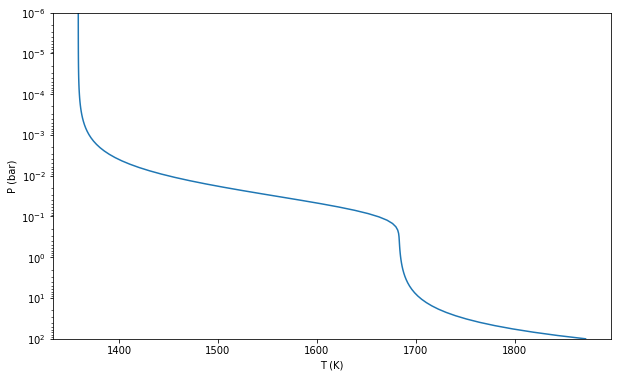

<Figure size 720x432 with 0 Axes>

In [9]:
plt.plot(temperature, pressures)
plt.yscale('log')
plt.ylim([1e2, 1e-6])
plt.xlabel('T (K)')
plt.ylabel('P (bar)')
plt.show()
plt.clf()

We can then compare the emission spectra considering the three geometries.
As ``do_scat_emis = True``, these calculations will both contain the scattering of the stellar and the self-scattering of the planetary light.

Using Rstar value input by user.
Using Rstar value input by user.
Using Rstar value input by user.


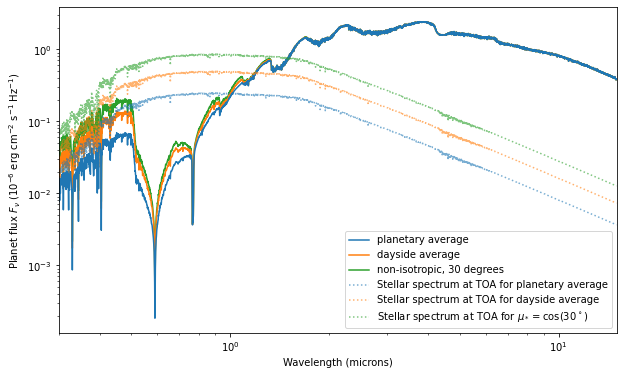

In [10]:
atmosphere.calc_flux(temperature, mass_fractions, gravity, MMW, \
                       Kzz = Kzz, fsed=fsed, sigma_lnorm = sigma_lnorm, \
                       geometry = 'planetary_ave', Tstar = 5778, \
                       Rstar = nc.r_sun, semimajoraxis = 0.05*nc.AU)
plt.plot(nc.c/atmosphere.freq/1e-4, atmosphere.flux/1e-6, \
                       label = 'planetary average', zorder = 2)  

atmosphere.calc_flux(temperature, mass_fractions, gravity, MMW, \
                       Kzz = Kzz, fsed=fsed, sigma_lnorm = sigma_lnorm, \
                       geometry = 'dayside_ave', Tstar = 5778, \
                       Rstar = nc.r_sun, semimajoraxis = 0.05*nc.AU)  
plt.plot(nc.c/atmosphere.freq/1e-4, atmosphere.flux/1e-6, \
                       label = 'dayside average', zorder = 1)  

  
atmosphere.calc_flux(temperature, mass_fractions, gravity, MMW, \
                       Kzz = Kzz, fsed=fsed, sigma_lnorm = sigma_lnorm, \
                       geometry = 'non-isotropic', Tstar = 5778, \
                       Rstar = nc.r_sun, semimajoraxis = 0.05*nc.AU,\
                       theta_star = 30.)    
plt.plot(nc.c/atmosphere.freq/1e-4, atmosphere.flux/1e-6, \
                       label = 'non-isotropic, 30 degrees', zorder = 0)  

plt.plot(nc.c/atmosphere.freq/1e-4, atmosphere.stellar_intensity/4.*np.pi/1e-6, \
             label = r'Stellar spectrum at TOA for planetary average',alpha=0.6, \
             color = 'C0', linestyle = ':')

plt.plot(nc.c/atmosphere.freq/1e-4, atmosphere.stellar_intensity/2.*np.pi/1e-6, \
             label = r'Stellar spectrum at TOA for dayside average',alpha=0.6, \
             color = 'C1', linestyle = ':')

plt.plot(nc.c/atmosphere.freq/1e-4, atmosphere.stellar_intensity*np.cos(30./180.*np.pi)*np.pi/1e-6, \
             label = r'Stellar spectrum at TOA for $\mu_*={\rm cos}(30^\circ)$',alpha=0.6, \
             color = 'C2', linestyle = ':')



plt.legend(loc='best')  
plt.xlim([0.3, 15])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (microns)')  
plt.ylabel(r'Planet flux $F_\nu$ (10$^{-6}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')  
plt.show()


We also plotted the stellar flux scaled at the top of the atmosphere for comparison using the `stellar_intensity` attribute. As this is an intensity we have to multiply it by $\pi$ to transform it to flux units. Furthermore we need to multiply the resulting flux by 1/4 to be consistent with the planetary average geometry. For the dayside average the multiplying factor is 1/2, whereas for an incidence angle of $\vartheta_*$ the factor is $\mu_* = {\rm cos}\vartheta_*$. *For convenience during plotting we already multiplied this value by $(R_*/d)^2$, where $R_*$ is the stellar radius and $d$ the distance between planet and star.*

## Surface scattering

For smaller exoplanets with thin atmospheres, the surface may contribute to the emission spectrum. In the non-scattering version of pRT the surface emits like a blackbody. Here we explain how pRT can be used to also include the scattering of light at the planetary surface, which will be described in detail in an upcoming paper (Alei et al., in prep.). In addition to the reflectivity of the surface (aka surface albedo), also the emissivity can be defined. The surface scattering is assumed to be an isotropic, that is Lambertian, process.

To start, let's define an Earth-like planet neglecting clouds. We assume a ground pressure of 1 bar which results in an atmosphere thin enough to not absorb all of the radiation emitted and scattered by the surface. We also include O3 here, please note that the [HITRAN](https://hitran.org) line lists we use for O$_3$ are limited to the NIR/MIR range (excluding the UV). The P-T profile for our simple example is chosen to lead to roughly the right temperatures as observed for Earth's atmosphere, neglecting the temperature version of its stratospheric region.

In [11]:
atmosphere = Radtrans(line_species = ['H2O_HITEMP',
                                      'CH4',
                                      'CO2',
                                      'O3'],
                      rayleigh_species = ['N2', 'O2'],
                      continuum_opacities = ['N2-N2', 'N2-O2','O2-O2','CO2-CO2'],
                      wlen_bords_micron = [0.3, 15],
                      do_scat_emis = True)

pressures = np.logspace(-6, 0, 100) 
atmosphere.setup_opa_structure(pressures) 
R_pl = nc.r_earth 
gravity = nc.G*(nc.m_earth)/R_pl**2 

# P-T parameters 
kappa_IR = 0.0009
gamma = 0.01 
T_int = 250. 
T_equ = 220. 
temperature = nc.guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)        

# Mean molecular weight of Earth's atmosphere
MMW = 28.7 * np.ones_like(temperature)

# Absorber mass fractions
mass_fractions = {}
mass_fractions['N2'] = 0.78 * 28. / MMW * np.ones_like(temperature)
mass_fractions['O2'] = 0.21 * 32. / MMW* np.ones_like(temperature)
mass_fractions['H2O_HITEMP'] = 0.001 * 18. / MMW * np.ones_like(temperature)
mass_fractions['O3'] = 1e-7 * 48. / MMW * np.ones_like(temperature)
mass_fractions['CO2'] = 0.0004 * 44. / MMW * np.ones_like(temperature)
mass_fractions['CH4'] = 0.0001 * 16. / MMW* np.ones_like(temperature)

  Read line opacities of CH4...
 Done.
  Read line opacities of CO2...
 Done.

  Read CIA opacities for N2-N2...
  Read CIA opacities for O2-O2...
  Read CIA opacities for CO2-CO2...
  Read CIA opacities for N2-O2...
 Done.



Note that we used the molecular weight $\mu_i$ and the mean molecular weight $\mu$ to convert from volume mixing ratios to mass fractions here, which is what is needed by pRT. The conversion factor is $\mu_i/\mu$, so ``28. / MMW`` for N$_2$, for example.

This is the P-T profile we are using for our simple setup:

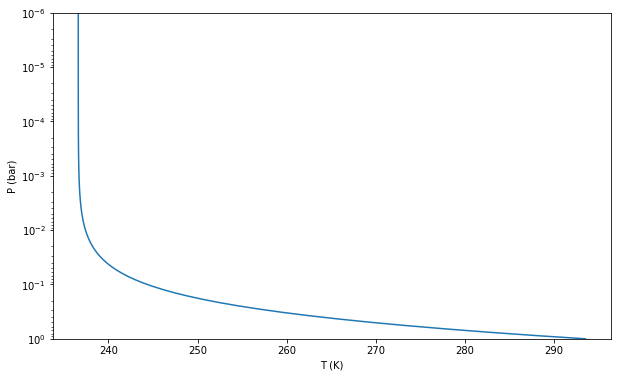

<Figure size 720x432 with 0 Axes>

In [12]:
plt.plot(temperature, pressures)
plt.yscale('log')
plt.ylim([1e0, 1e-6])
plt.xlabel('T (K)')
plt.ylabel('P (bar)')
plt.show()
plt.clf()

By default, the highest pressure (lowest altitude) layer of the atmosphere will always be treated as the location of the surface of the planet by pRT. This is no hindrance when calculating the spectra of gas giant planets, as long as we chose the largest pressure deep enough, such that the surface never becomes visible.

As the planetary surface is visible in our case here, it makes sense to vary a few extra variables: the reflectance and the emissivity of the surface. The reflectance determines the fraction of light that is scattered back from the surface layer; the emissivity determines the fraction of thermal radiation emitted by the surface when compared to a blackbody.

It is possible to change the value of the surface reflectance and of the surface emissivity by filling it with an array with as many elements as the wavelengths/frequencies considered by pRT. In this way, wavelength-dependent reflectance / emissivity values can be considered. Constant values of reflectivity and emissivity can be also considered by filling the array with the same value.
The default values of reflectance and emissivity (i.e., if you don't provide any values for them) are 0 and 1, respectively.  

In this example, we vary the surface reflectance of a cloud-free Earth-like planet, orbiting a Sun-like star at 1 AU, with a planetary-averaged insolation redistribution. 

Using Rstar value input by user.
Using Rstar value input by user.
Using Rstar value input by user.


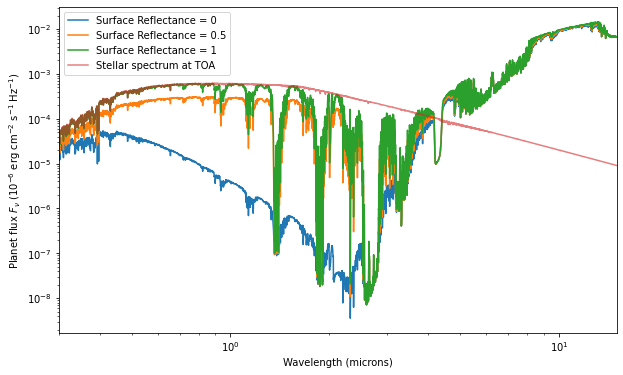

In [13]:
for r in [0,0.5,1]:
    
    atmosphere.reflectance = r * np.ones_like(atmosphere.freq)
    
    atmosphere.calc_flux(temperature, mass_fractions, gravity, MMW, \
                           Kzz = Kzz, fsed=fsed, sigma_lnorm = sigma_lnorm, \
                           geometry='planetary_ave',Tstar= 5778, \
                           Rstar=nc.r_sun, semimajoraxis=nc.AU)

    plt.semilogy(nc.c/atmosphere.freq/1e-4, atmosphere.flux/1e-6, \
             label = 'Surface Reflectance = '+str(r), zorder = 2)
    
plt.semilogy(nc.c/atmosphere.freq/1e-4, atmosphere.stellar_intensity/4.*np.pi/1e-6, \
             label = 'Stellar spectrum at TOA',alpha=0.6)
    
plt.legend(loc='best')
plt.xlim([0.3, 15])
plt.xscale('log')
plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Planet flux $F_\nu$ (10$^{-6}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')
plt.show()


We can also get the emission spectra of this atmosphere assuming a more Earth-like surface reflectivity (average value of 0.3 up to 3 $\mu m$, 0 in the IR).

In [14]:
atmosphere.reflectance = [0.3 if l<=3. else 0 for l in nc.c/atmosphere.freq/1e-4 ]

atmosphere.calc_flux(temperature, mass_fractions, gravity, MMW, \
                           geometry='planetary_ave',Tstar= 5778, \
                           Rstar=nc.r_sun, semimajoraxis=nc.AU)

Using Rstar value input by user.


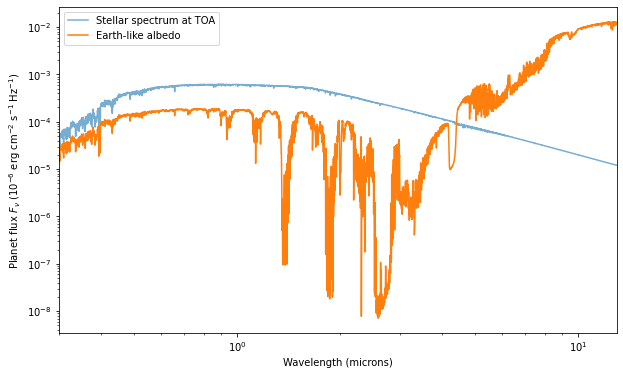

In [15]:
plt.semilogy(nc.c/atmosphere.freq/1e-4, atmosphere.stellar_intensity/4.*np.pi/1e-6, \
             label = 'Stellar spectrum at TOA',alpha=0.6)
plt.semilogy(nc.c/atmosphere.freq/1e-4, atmosphere.flux/1e-6, \
             label = 'Earth-like albedo', zorder = 2)

    
plt.legend(loc='best')
plt.xlim([0.3, 13.])
plt.xscale('log')


plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Planet flux $F_\nu$ (10$^{-6}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')
plt.show()



Finally here an example for a surface reflectivity of 1, as a function of different incidence angles.

Using Rstar value input by user.
Using Rstar value input by user.


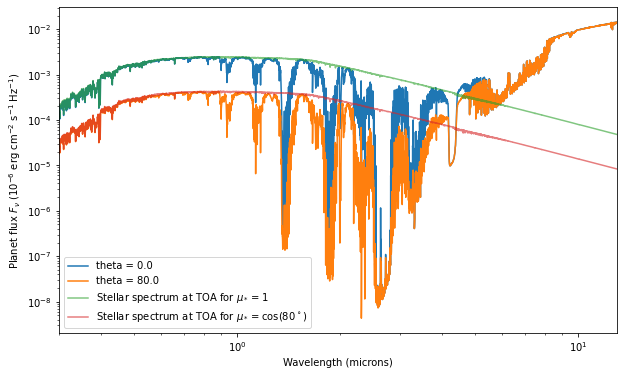

In [16]:
atmosphere.reflectance = np.ones_like(atmosphere.freq)

pressures = np.logspace(-6, 0, 100) 
atmosphere.setup_opa_structure(pressures) 

thetas = [0., 80.]

for theta in thetas:
    atmosphere.calc_flux(temperature, mass_fractions, gravity, MMW, \
                           Tstar= 5778, \
                           Rstar=nc.r_sun, semimajoraxis=nc.AU, \
                           geometry = 'non-isotropic', \
                           theta_star = theta)

    plt.semilogy(nc.c/atmosphere.freq/1e-4, atmosphere.flux/1e-6, \
             label = 'theta = '+str(theta), zorder = 2)

plt.semilogy(nc.c/atmosphere.freq/1e-4, atmosphere.stellar_intensity*np.pi/1e-6, \
             label = r'Stellar spectrum at TOA for $\mu_*=1$',alpha=0.6)

plt.semilogy(nc.c/atmosphere.freq/1e-4, atmosphere.stellar_intensity*np.cos(80./180.*np.pi)*np.pi/1e-6, \
             label = r'Stellar spectrum at TOA for $\mu_*={\rm cos}(80^\circ)$',alpha=0.6)

plt.legend(loc='best')
plt.xlim([0.3, 13.])
plt.xscale('log')


plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Planet flux $F_\nu$ (10$^{-6}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')
plt.show()